In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
from matplotlib import pyplot as plt
%matplotlib inline
import importlib 

datafolder = 'workdata'
paysdf = {}

In [2]:
# LOAD tables
payslist = ['France','Germany','Italy','Spain','Belgium','United Kingdom']
for paysname in payslist:
    filepath = datafolder+'/incidence_'+paysname+'_Table.csv'
    paysdf[paysname] = pd.read_csv(filepath)

testdf = paysdf['France']
testdf

,Confirmed,Deaths,Recovered,Active,Date,Confirmed_brutincidence,Confirmed_MMincidence,Confirmed_eMMincidence,Deaths_brutincidence,Deaths_MMincidence,Deaths_eMMincidence,Recovered_brutincidence,Recovered_MMincidence,Recovered_eMMincidence,Active_brutincidence,Active_MMincidence,Active_eMMincidence
0,0,0,0,0,2020-01-22 00:00:00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00
1,0,0,0,0,2020-01-23 00:00:00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00,0,0.0,0.00
2,2,0,0,2,2020-01-24 00:00:00,2,0.7,0.20,0,0.0,0.00,0,0.0,0.00,2,0.7,0.20
3,3,0,0,3,2020-01-25 00:00:00,1,0.8,0.28,0,0.0,0.00,0,0.0,0.00,1,0.8,0.28
4,3,0,0,3,2020-01-26 00:00:00,0,0.6,0.25,0,0.0,0.00,0,0.0,0.00,0,0.6,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,2160343,48341,155829,1956173,2020-11-20 00:00:00,23247,26884.9,32493.23,1140,626.3,584.11,2684,1879.7,1732.73,19423,24378.9,30223.85
304,2178023,48593,156755,1972675,2020-11-21 00:00:00,17680,24825.6,31011.90,252,611.7,550.90,926,1728.4,1652.06,16502,22485.4,28851.67
305,2191180,48807,157259,1985114,2020-11-22 00:00:00,13157,22815.4,29226.41,214,599.1,517.21,504,1704.7,1537.25,12439,20511.6,27210.40
306,2195940,49312,158170,1988458,2020-11-23 00:00:00,4760,22092.4,26779.77,505,598.6,515.99,911,1682.0,1474.63,3344,19811.9,24823.76


## PREPARATION FUNCTIONS

In [3]:
# FUNCTION - 1  : PRIOR SI DATA
# FUNCTION - 2  : STARTING TIME FRAME
# FUNCTION - 3 : TIME STEPS DEFINITION
# FUNCTION - 4 : DiscreteShifted Gamma SIDistr
# FUNCTION - 5 - serial interval definition
# FUNCTION - 6 & 7 : LAMBDA & CALCULATE POSTERIOR

#EXEC TEST
#testposterior = CalculatePosterior(testIncidenceSerie, aPrior, bPrior, SI_mean, SI_stdev, range(12,18))
#testposterior = CalculatePosterior(testIncidenceSerie, aPrior, bPrior, SI_mean, SI_stdev, range(25,35))
#print(testposterior)
#print(testposterior[0] * testposterior[1]) # TEST VALUE : 1.52470320666128
#print(math.sqrt(testposterior[0]) * testposterior[1]) # TEST VALUE : 0.539063988363533

#LambdaCalc(20, SImean,SIstdev, IncidenceSerie)

# FUNCTION - 8 : COMPUTE MU & SIGMA SAMPLE ON UNCERTAINTY PARAMETERS
# lots of verification to add about this one

#mu,sigma = compute_mu_sigma_distrib(samplesizeperSIdistr,SI_mean,SI_stdev,mean_vars,stdev_vars)
#fig = plt.figure(figsize=(10, 5))
#plt.scatter(mu,sigma)

from utils_R import get_abPrior, \
search_StartingTimeStep, \
get_TimeStepSlices, \
DiscreteShiftedGammaSIDistr, \
FinalSIDistributionWithoutUncertainty, \
LambdaCalc, \
CalculatePosterior, \
compute_mu_sigma_distribution
                    

def getTimeSteps_custom(): pass

In [4]:
# FUNCTION EXEC TESTS
from TEST_utils_R import launch_utils_R_TESTS
launch_utils_R_TESTS()

STARTING TESTS ON UTILS_R FUNCTION
TEST get_abPrior : OK
TEST search_starting_timestep : starting
ERROR : The epidemic is too small to ever get the desired posterior CV. Estimation aborted. Try a higher value for the aimed posterior CV.
TEST search_starting_timestep : OK
TEST get_TimeStepSlices : starting
ERROR : The epidemic is too small to ever get the desired posterior CV. Estimation aborted. Try a higher value for the aimed posterior CV.
TEST get_TimeStepSlices : OK
TEST DiscreteShiftedGammaSIDistr : OK
TEST TEST_FinalSIDistributionWithoutUncertainty : OK


# ESTIMATION OF R PROCESS

In [40]:
# INCIDENCE SERIE (supplementary cases per days column)
# can be mesured on confirmedcases, hostitalisation cases, or reanimation cases
# as long as there is NO negative values

IncidenceSerie = testdf['Confirmed_MMincidence']  
TimeMaxnb = IncidenceSerie.shape[0]    
print('length of current time serie : {} days'.format(TimeMaxnb))

# =============================
#  PREDEFINED PARAMETERS
# =============================
# A - TYPE OF CALCULATION
UNCERTAINTY_FLAG = False
# FALSE will build the SI_distribution with only 'main' fixed values of input mean and std, it is fairly quick
# TRUE will build SI_distribution by iterating to find most probable value of MEAN and STD around main value,
# it is a lot slower

# PARAMETERS TO BUILD THE SERIAL INTERVAL DISTRIBUTION
# MAIN VALUES : mandatory for all types of computation
# must : SI_mean > 1; SI_mean > ComputationStep; SI_stdev > 0
SI_mean = 7
SI_stdev = 4

# UNCERTAINTY DISTRIBUTION PARAMETERS
# must : 
# mean_vars['std'] > 0 ;mean_vars['min'] > 1; mean_vars['min'] < SI_mean; mean_vars['MAX'] > SI_mean;
# stdev_vars['std'] > 0; stdev_vars['min'] > 0; stdev_vars['min'] < SI_stdev; stdev_vars['MAX'] > SI_stdev
mean_vars = {'std':1,
             'MAX':12.4,
             'min':4.4}
stdev_vars = {'std':0.5,
            'MAX':5.8,
            'min':1.8}

# must : SampleSizeSI > 0
uncertaintySampleSize = 5
posteriorSamplesize = 5

# TIME INTERVALS FOR COMPUTATION
# must : CVThreshold > 0
# must  : ComputationLength > 1 ; ComputationLength < TimeMaxnb; ComputationStep > 1
# DETERMINE STARTING POINT : low values will skip more of the first days for computation
CVThreshold = 0.3 
# ComputationLength : average of R computation over a time frame (7 = average on 1 week)
ComputationLength=7
# ComputationStep >> 1 = every day ; 7 = every weeks
ComputationStep=2

#Prior starting values of mean/std
# must : MeanPrior >0 ; StdPrior >0
MeanPrior = 5
StdPrior = 5

length of current time serie : 308 days


all params and input check seems good


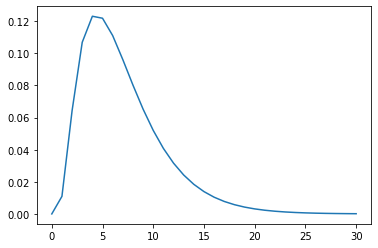

In [41]:
# ===============================
# Checks on INPUTS and PARAMETERS 
# ===============================
import utils_R
#importlib.reload(utils_R)

GOLOOP_FLAG =True
if not UNCERTAINTY_FLAG :
    if not utils_R.fullcheck_serial(IncidenceSerie,SI_mean,SI_stdev,
                        MeanPrior,StdPrior,CVThreshold,
                        ComputationLength,ComputationStep) : GOLOOP_FLAG = False
    GOLOOP_FLAG,visuMeanSIFinal,visusdSIFinal,visuSIDistr = utils_R.FinalSIDistributionWithoutUncertainty(SI_mean,SI_stdev,TimeMaxnb)
    
    #VISUALISATION OF DISTRIBUTION
    stopplot = round(SI_mean+3*SI_stdev)
    for i in range(round(SI_mean),TimeMaxnb):
        if visuSIDistr[i]< 0.0001 : 
            stopplot = i
            break
    plt.plot(range(stopplot),visuSIDistr[0:stopplot])

else :
    if not utils_R.fullcheck_uncertain(IncidenceSerie,SI_mean,SI_stdev,
                           MeanPrior,StdPrior,CVThreshold,
                           ComputationLength,ComputationStep,
                           mean_vars,stdev_vars,uncertaintySampleSize) : GOLOOP_FLAG = False
        
if GOLOOP_FLAG : print('all params and input check seems good')
else : print('ERRORS in params and input check, verify and correct')

In [42]:
# =============================
# R ESTIMATION 
# =============================
# local VARS 
aPosterior=[]
bPosterior=[]
MeanR=[]
StdR=[]
RQuantile025=[]
RQuantile05=[]
RQuantile25=[]
Rmedian=[]
RQuantile75=[]
RQuantile95=[]
RQuantile975=[]

# STEP 1
aPrior,bPrior = get_abPrior(MeanPrior,StdPrior)
CumulIncThreshold = 1 / (CVThreshold * CVThreshold) - aPrior
# Time steps
startTimes,endTimes = get_TimeStepSlices(IncidenceSerie,CumulIncThreshold,
                                 ComputationLength,ComputationStep)
# VERIF to implement ??
#  If (endTime(TimePeriodNb - 1) < StartEstimDate) : 
#    "Warning: you are trying to estimate R too early in the epidemic to get the desired posterior CV. Estimation will be performed anyway."
#  If any startTime[x] > endTime[x]) : "Time period X has its starting date after its ending date. Estimation aborted."
#  if any endTime[x] > TimeMaxnb : "Time period X ends after the end of the epidemic.  Estimation aborted.  

#computation visualization variable
compviz = len(startTimes)/10
i = 0
j = 1

if not UNCERTAINTY_FLAG:
    # =============================
    # R ESTIMATION WITHOUT UNCERTAINTY
    # =============================
    # LOOP ON TIME PERIODS
    for curStart,curEnd in zip(startTimes,endTimes):
        #Compute A & B posterior
        TimePeriodRange = range(curStart,curEnd)
        #print(TimePeriodRange)
        result = CalculatePosterior(IncidenceSerie,aPrior, bPrior, SI_mean, SI_stdev, TimePeriodRange)
        aPosterior.append(result[0])
        bPosterior.append(result[1])

        # compute mean and std using last computed a and b 
        MeanR.append(aPosterior[-1] * bPosterior[-1])
        StdR.append(math.sqrt(aPosterior[-1]) * bPosterior[-1]) 

        RQuantile025.append(stats.gamma.ppf(0.025, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile05.append(stats.gamma.ppf(0.05, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile25.append(stats.gamma.ppf(0.25, aPosterior[-1], scale=bPosterior[-1]))
        Rmedian.append(stats.gamma.ppf(0.5, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile75.append(stats.gamma.ppf(0.75, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile95.append(stats.gamma.ppf(0.95, aPosterior[-1], scale=bPosterior[-1]))
        RQuantile975.append(stats.gamma.ppf(0.975, aPosterior[-1], scale=bPosterior[-1]))

        if i > compviz :
            compviz = compviz + len(startTimes)/10
            print('{}0% complete'.format(j))
            j=j+1
        i=i+1
           
else : 
    # =============================
    # R ESTIMATION WITH UNCERTAINTY
    # =============================
    # COMPUTE UNCERTAINTY SAMPLE
    mu,sigma = compute_mu_sigma_distribution(uncertaintySampleSize,SI_mean,SI_stdev,mean_vars,stdev_vars)

    # LOOP ON TIME PERIODS
    for curStart,curEnd in zip(startTimes,endTimes) :
        #Compute A & B posterior
        TimePeriodRange = range(curStart,curEnd)
        #print(TimePeriodRange)   

        SampleR = []
        aPosterior_cur = []
        bPosterior_cur = []
        # LOOP ON SAMPLESIZE
        for k in range(len(mu)):
            result = CalculatePosterior(IncidenceSerie,aPrior, bPrior, mu[k], sigma[k], TimePeriodRange)    
            aPosterior_cur.append(result[0])
            bPosterior_cur.append(result[1])

            SampleR_curloop = []
            for l in range(posteriorSamplesize):
                SampleR_curloop.append(stats.gamma.ppf(np.random.random(), 
                                                       aPosterior_cur[-1],
                                                       scale=bPosterior_cur[-1]))
            SampleR.append(SampleR_curloop)
        sampleRprint = np.array(SampleR)

        # compute mean and std using last computed a and b 
        MeanR.append(np.mean(sampleRprint))
        StdR.append(np.std(sampleRprint))
        aPosterior.append(np.mean(aPosterior_cur))
        bPosterior.append(np.mean(bPosterior_cur))

        percentiles = np.percentile(sampleRprint,[2.5,5,25,50,75,95,97.5])

        RQuantile025.append(percentiles[0])
        RQuantile05.append(percentiles[1])
        RQuantile25.append(percentiles[2])
        Rmedian.append(percentiles[3])
        RQuantile75.append(percentiles[4])
        RQuantile95.append(percentiles[5])
        RQuantile975.append(percentiles[6])

        if i > compviz :
            compviz = compviz + len(startTimes)/10
            print('{}0% complete'.format(j))
            j=j+1
        i=i+1
        
print('computation complete')

10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
computation complete


In [38]:
incidencelist = IncidenceSerie.loc[(IncidenceSerie.index >= endTimes[0]-1)]
incidencelist = []
#VISUALISATION OF DISTRIBUTION
for val in endTimes:
    incidencelist.append(IncidenceSerie[val-1])

# DATAFRAMING RESULTS
testdict = {'timestep':endTimes,
            'incidence':incidencelist,
            'aPosterior':aPosterior,
            'bPosterior':bPosterior,
            'MeanR':MeanR,
            'StdR':StdR,
            'RQuantile025':RQuantile025,
            'RQuantile05':RQuantile05,
            'RQuantile25':RQuantile25,
            'Rmedian':Rmedian,
            'RQuantile75':RQuantile75,
            'RQuantile95':RQuantile95,
            'RQuantile975':RQuantile975}

rsltdf = pd.DataFrame(testdict)
rsltdf

,timestep,incidence,aPosterior,bPosterior,MeanR,StdR,RQuantile025,RQuantile05,RQuantile25,Rmedian,RQuantile75,RQuantile95,RQuantile975
0,22,0.7,4.7,0.351061,1.649988,0.761083,0.511872,0.626411,1.094092,1.534559,2.080718,3.067715,3.442156
1,29,0.1,2.9,0.276294,0.801253,0.470512,0.159154,0.211876,0.455442,0.711276,1.049841,1.698023,1.952122
2,36,0.9,2.4,0.522938,1.255051,0.810132,0.197828,0.275481,0.659329,1.085701,1.668143,2.813289,3.268685
3,43,38.6,131.9,0.066227,8.735348,0.760603,7.308277,7.523034,8.211011,8.713282,9.235634,10.022932,10.287804
4,50,286.4,1062.3,0.004450,4.727402,0.145044,4.447360,4.491383,4.628780,4.725919,4.824407,4.968481,5.015874
5,57,975.9,4299.2,0.000747,3.213237,0.049006,3.117897,3.133057,3.180049,3.212988,3.246154,3.294267,3.309993
6,64,2353.7,12037.5,0.000199,2.394279,0.021823,2.351696,2.358498,2.379524,2.394213,2.408962,2.430287,2.437239
7,71,4592.7,24962.7,0.000078,1.937498,0.012263,1.913536,1.917371,1.929212,1.937472,1.945755,1.957712,1.961606
8,78,3615.4,29443.0,0.000041,1.214465,0.007078,1.200632,1.202846,1.209683,1.214451,1.219231,1.226130,1.228376
9,85,7218.3,40203.5,0.000035,1.395902,0.006962,1.382290,1.384471,1.391200,1.395891,1.400591,1.407373,1.409580


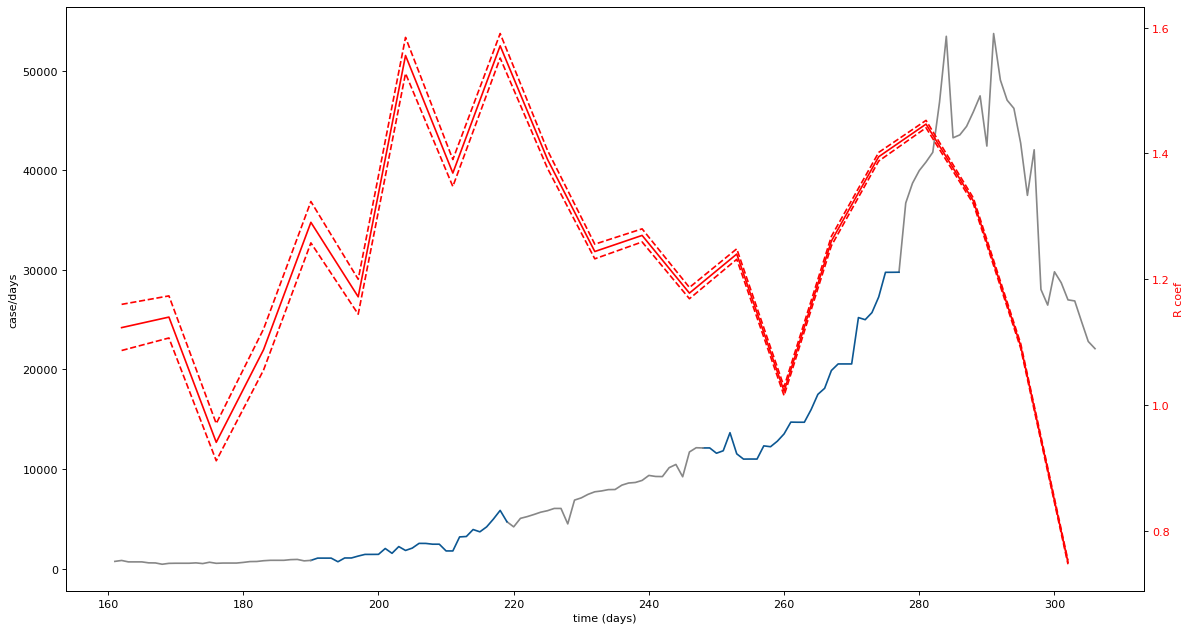

In [39]:
from matplotlib.pyplot import figure

# VISUALISATION
rangeselection = 150
if rangeselection <= IncidenceSerie.shape[0] :
    index = IncidenceSerie.shape[0]-rangeselection
else : index = 0
#print(index)

Rtable = rsltdf[['timestep','MeanR','RQuantile025','RQuantile975']].loc[rsltdf['timestep'] > index]

# X inc sections CONSTRUCTION
xsections = []
incsections =[]
rangesection = 30 # 30 = month ; 7 = week

lastvalue = IncidenceSerie.shape[0]-1
i=1

while True:
    startval = max(lastvalue-rangesection,0)
    if startval < index : break
    x = np.array(range(startval,lastvalue))
    
    #r = y2[startval:lastvalue]
    i = IncidenceSerie[startval:lastvalue]
    xsections.append(x)
    #Rsections.append(r)
    incsections.append(i)
    lastvalue = startval+1
    if startval == 0 : break

#figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots(figsize=(15, 8), dpi=80)

ax1.set_xlabel('time (days)')
ax1.set_ylabel('case/days')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('R coef',color='red')  # we already handled the x-label with ax1

colors = ['#878787', '#0c5792']
for i,val in enumerate(xsections):
    ax1.plot(xsections[i], incsections[i], color=colors[i%2]) # plt.plot(x, y, "y-", color=colors[i%2])

#ax1.tick_params(axis='y', labelcolor=color)
ax2.plot(Rtable['timestep'], Rtable['MeanR'], color='red')
ax2.plot(Rtable['timestep'], Rtable['RQuantile025'], color='red',linestyle = '--')
ax2.plot(Rtable['timestep'], Rtable['RQuantile975'], color='red',linestyle = '--')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()